# Distributed Algorithms: || k-means
## <span style="color:green">2nd notebook</span>
### <span style="color:blue">Group 20: Dall'Ara, Verguizas I Moliner</span>

###  <span style="color:red">KDD Dataset</span>


The dataset we have worked with is the kdd99 dataset which contains network traffic data of different types of malicius activity attacks. Therefore, our goal is to group the points of our dataset in k different clusters based on their similarity. Following we can see the schema of this dataset as well as the different types of attacks labels.

In [6]:
from sklearn.datasets import fetch_kddcup99

kdd_data = fetch_kddcup99(as_frame=True)["frame"]
kdd = spark.createDataFrame(kdd_data)
kdd.printSchema()

root
 |-- duration: long (nullable = true)
 |-- protocol_type: binary (nullable = true)
 |-- service: binary (nullable = true)
 |-- flag: binary (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: d

In [8]:
# separate labels
labels = kdd.select("labels")

unique_labels = labels.distinct().rdd.flatMap(lambda x: x).collect()

unique_labels = [item.decode('utf-8').rstrip('.') for item in unique_labels]

print(f"Unique labels: {unique_labels}\n\nTotal amount of labels: {len(unique_labels)}")

Unique labels: ['smurf', 'pod', 'guess_passwd', 'teardrop', 'normal', 'land', 'ftp_write', 'back', 'nmap', 'ipsweep', 'multihop', 'neptune', 'warezmaster', 'imap', 'satan', 'phf', 'portsweep', 'loadmodule', 'buffer_overflow', 'perl', 'rootkit', 'warezclient', 'spy']

Total amount of labels: 23


###  <span style="color:red">Data Preprocessing</span>

Before applying our kmeans algorithm to the kdd99 dataset, we need to apply some preprocessing steps. Our processing has consisted on removing the cathegorical columns and the columns with 0 variance as well as to standarize the remaining columns in order to bring all features to a similar scale.

In [7]:
#drop cathegorical columns.
categorical_columns = ['protocol_type', 'service', 'flag', 'labels']
kdd = kdd.drop(*categorical_columns)

kdd.createOrReplaceTempView("kdd_table")

# drop columns with variance equal to 0.
for coll in kdd.columns:
    if spark.sql("SELECT VARIANCE(" + coll + ") FROM kdd_table").collect()[0][0] == 0:
        kdd = kdd.drop(coll)

#standarize the remaining data columns.
for col_name in kdd.columns:
    avg_val = kdd.agg({col_name: 'avg'}).collect()[0][0]
    std_val = kdd.agg({col_name: 'stddev'}).collect()[0][0]
    kdd = kdd.withColumn(col_name, (kdd[col_name] - avg_val) / (std_val))


###  <span style="color:red">Distributed Analysis: Random Initialization</span>

Now we implement a parallelized version of LLoyd iterations together with a random initialization of the clusters.

In [1]:
# Function to calculate Euclidean distance between two points x and y
def euclidean_distance(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))

# Function to find the index of the minimum value in a list x
def argmin(x):
    return x.index(min(x))

# Function to initialize K-Means with random centers
def random_choice_init(data, k):
    # Select relevant columns and take k random samples
    three_dim_array = np.array(data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(False, k))
    final = three_dim_array.reshape(three_dim_array.shape[0], -1)
    return final

# Main K-Means function
def kmeans(data, centers, max_iter=100, perc=0.999999, return_cost=False):
    count = 0

    # Get column names
    cols = data.columns

    # Initialize cost history 
    cost = [float("inf")]

    # Main K-Means loop
    while count <= max_iter:
        print("Iteration", count)

        # Define a UDF to find the index of the nearest center for each row
        argmin_distance_udf = udf(lambda row: (argmin([euclidean_distance(row, c) for c in centers])), IntegerType())

        # Calculate the "centr" column based on the nearest center
        data = data.withColumn("centr", argmin_distance_udf(array([c for c in cols if c not in ignored_cols])))

        # Update the centers based on the assigned clusters
        
        centers = np.array(data.groupBy("centr").mean().select(*[col("avg("+c+")") for c in data.columns if c not in ignored_cols+['avg(centr)']]).collect())

        # Calculate the cost value per element, then sum
        get_cost = udf(lambda row: str(min([euclidean_distance(row, cen)**2 for cen in centers])))

        data = data.withColumn("cost", get_cost(array([c for c in cols if c not in ignored_cols])).cast("double"))

        # Calculate the new cost and add it to the cost history
        finalcost = data.select("cost").groupBy().sum().collect()[0][0]
        cost.append(finalcost)
        
        print("Cost function values", cost[count])

        # Increment the iteration count
        count += 1

        # Break if the cost change ratio is below the specified threshold
        if cost[-1] / cost[-2] > perc:
            break

    # Return the result based on whether cost history is requested
    if return_cost:
        return data, centers, cost[1:]
    else:
        return data, centers

We will compute both the cost function and the time it takes for each iteration. We will then average by a number of iterations(in our case 5). We will repeat this for every configuration of partitions and cores per worker that we choose. In our case these values will be [1, 2, 3 and 4] possible cores per worker and [8, 16, 32, 64] number of partitions.

In [9]:
def avg_cost_time_results(k, data, partitions, iterations, func, L=None):
    
    total_cost_history = np.zeros(len(partitions))
    total_time = np.zeros(len(partitions))
    
    for part in partitions:
        part_cost = np.zeros(iterations)
        part_time = np.zeros(iterations)
        for i in range(iterations):
            start_time = time.time()
            data = data.repartition(int(part))
            data = data.persist()
            r_centr = func(data, k, L)
            result, final_centroids, cost_history = kmeans(data, r_centr, max_iter=15, return_cost=True)
            part_cost[i] = cost_history[-1]
            elapsed_time = time.time() - start_time
            part_time[i] = elapsed_time
#            total_cost_history[np.where(partition==part), i] = cost_history[-1]
#            total_time[np.where(partition==part), i] = elapsed_time
        total_cost_history[np.where(partitions==part)] = np.mean(part_cost)
        total_time[np.where(partitions==part)] = np.mean(part_time)
    
    return total_cost_history, total_time


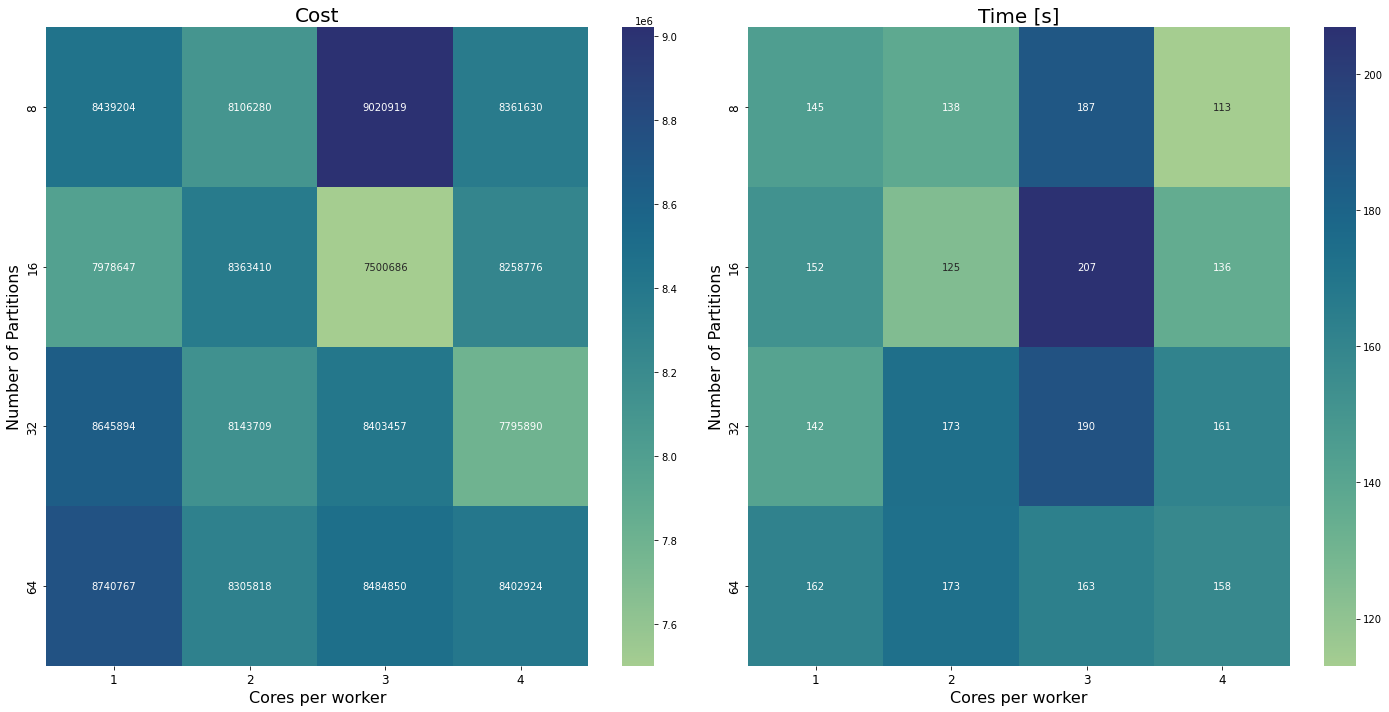

###  <span style="color:red">Distributed analysis: Parallel Initialization</span>


Now we do the same but with a kmeans parallel initialization.

In [2]:
def kmeans_Lloyd(X, centroids, k, max_iters=100, tol=1e-7):
    
    """ Run the sequential LLoyd algorithm given data X, centroids and k number of clusters."""

    costs = []

    for _ in range(max_iters):
        # Step 1: Assign each data point to the nearest centroid
        distances = euclidean_distances(X, centroids)
        labels = np.argmin(distances, axis=1)
        
        # Step 2: Update centroids based on the assigned points
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Calculate the cost function (sum of squared distances to centroids)
        cost = np.sum(np.min(distances, axis=1))
        costs.append(cost)

        
        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) <= tol:
            break
        
        centroids = new_centroids
    
    return centroids, labels, costs



def kmeans_ll(data, k, L=1): 
    
    """ || kmeans initialization of k centroids elements. X is the data, L the oversampling factor."""
    
    
    cols = data.columns
    n_samples, n_features = data.count(), len(data.columns)
    centroids = np.zeros((1, n_features))
    
    # Step 1: Choose one random point as the first centroid
    three_dim_array = np.array(data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(False, 1))
    centroids[0] = three_dim_array.reshape(three_dim_array.shape[0], -1)
    
    # Define a UDF to find psi
    # Calculate the distance using the UDF and collect the result
    distance_udf = udf(lambda row: ((float(euclidean_distance(row, centroids[0])))), DoubleType())

    distance = data.withColumn("distance", distance_udf(array([c for c in cols if c not in ignored_cols])))

    # Sum the distances
    psi = distance.select(spark_sum(col("distance"))).collect()[0][0]
    #print(psi)

    

    # Calculate psi
    #psi = spark_sum(distance_udf(array([c for c in cols if c not in ignored_cols])).collect())

    
    for j in range(1, int(np.log(psi))):

        # Step 2: Compute distances from each point to the nearest centroid and define probabilities
        min_distance_udf = udf(lambda row: (float(min([euclidean_distance(row, c) for c in centroids]))), DoubleType())
        data = data.withColumn("probs", min_distance_udf(array([c for c in cols if c not in ignored_cols])))
        # Calculate the sum of the "probs" column
        total_sum = data.select(spark_sum(col("probs"))).collect()[0][0]
        # Normalize the "probs" column by dividing each row's value by the total sum
        data = data.withColumn("probs", col("probs")*L / total_sum)
        
        # Sample and add centroids
        # Generate a random column for filtering
        data = data.withColumn("rand_col", rand())

        # Filter and select the rows where 'rand_col' is less than 'probs' to get n_samples
        selected_data = data.filter(col("rand_col") < col("probs")).select([col(c) for c in data.columns if c not in ['rand_col','centr','cost','probs']]).collect()

        #print("centroids", centroids)
        #print("selected_data", selected_data)
        if selected_data != []:
            centroids = np.concatenate((centroids, selected_data), axis=0)
                
    if len(centroids) > k:
                
        #A SORT OF K MEANS ++ INITIALIAZATION FOR Lloyd ITERATIONS ON CENTROIDS       
        cc = np.copy(centroids)
        p_centroids = np.zeros((k, n_features))

        for j in range(0, k):
            
            # Define weights
            w = np.zeros(len(cc))

            # Create new column with the index of the nearest center for each row
            argmin_distance_udf = udf(lambda row: (argmin([euclidean_distance(row, c) for c in cc])), IntegerType())
            data = data.withColumn("index", argmin_distance_udf(array([c for c in cols if c not in ignored_cols])))

            #w = np.array(data.groupBy("index").count().collect())
            # Group by 'centroid_inddex' and count the occurrences, renaming the count column
            centroid_counts = data.groupBy("index").count()
            # Order by ascending index value
            centroid_counts = centroid_counts.sort("index")
            # Calculate the sum of counts
            total_count = centroid_counts.select(spark_sum(col("count"))).collect()[0][0]
            # Normalize the "probs" column by dividing each row's value by the total sum
            renormalized_counts = centroid_counts.withColumn("count", col("count")/ total_count).select(col("count")).collect()
            probs = np.array(renormalized_counts).flatten()

            next_centroid_idx = np.random.choice(len(probs), p=probs)
            p_centroids[j] = cc[next_centroid_idx]
            cc = np.delete(cc, next_centroid_idx, axis=0)

        #print(len(centroids), len(p_centroids))
        # K MEANS Lloyd ITERATIONS ON CENTROIDS

        final_centroids, __, _ = kmeans_Lloyd(centroids, p_centroids, k)
    else:
        final_centroids = centroids
        
    return final_centroids


Again we compute the cost and time and we average it for 5 iterations. We then repeat the process for the same configurations of partitions and cores that we worked with random kmeans initialization ([1, 2, 3 and 4] possible cores per worker and [8, 16, 32, 64] number of partitions).

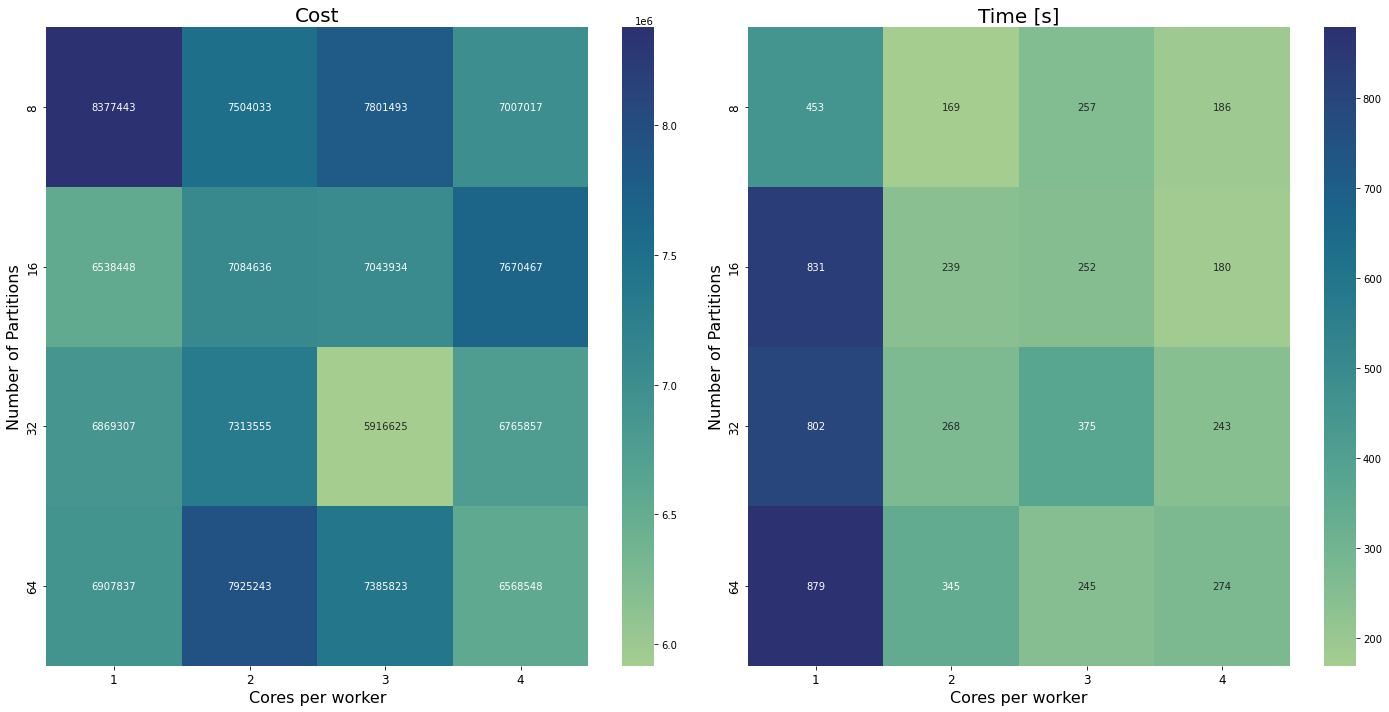

###  <span style="color:red">Comparison between Random and Parallel initialization K-means algorithm</span>


Now we can plot the average cost for both random initialization and parallel initialization of the kmeans parallel implementation for the two best configurations. As we can see, the average cost is lower when we apply a parallel initialization at the expenses of a bigger execution time.

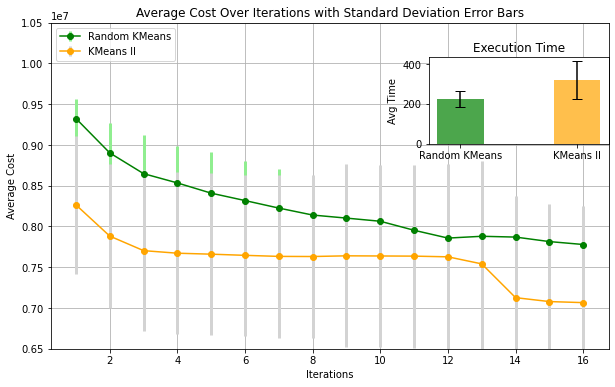